# Team 21 - Ice Analyzers

#### Predicting the velocity of drifting sea ice

In [85]:
#Import packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [88]:
#Import training set
df1 = pd.read_csv('DRIFT_DATA_TRAIN.csv')

In [89]:
df1

,year,month,day,doy,x_EASE,y_EASE,u_buoy,v_buoy,id_buoy,u_ERA5,v_ERA5,sic_CDR,h_cs2smos,h_piomas,d2c
0,1979,2,18,49,147.506958,138.582672,-0.797554,1.114740,1906,-6.704156,-0.321260,0.990195,NaN,3.189743,522.523298
1,1979,2,18,49,146.834778,120.509880,0.643200,0.368754,1913,-6.818630,-0.674205,0.966372,NaN,2.484009,412.767669
2,1979,2,18,49,130.993561,129.623672,-1.162420,0.243717,1914,-8.825469,1.123955,0.996022,NaN,2.474106,362.547379
3,1979,2,18,49,147.524719,157.382492,0.919766,0.025784,1918,-1.079951,-1.035410,0.982681,NaN,3.740522,381.025629
4,1979,2,19,50,147.470963,138.599823,0.380940,1.243485,1906,-2.169171,2.537787,0.990302,NaN,3.188522,521.535334
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
339473,2019,12,30,364,193.232056,172.742004,-0.981225,-11.698400,44880,-2.526544,-6.012877,1.000000,1.414148,1.620020,702.312813
339474,2019,12,30,364,208.421234,142.049896,-7.247925,-5.289890,53005,-4.615093,-0.381765,1.000000,1.039972,1.288953,360.491321
339475,2019,12,30,364,145.264023,146.109741,-0.913761,2.182150,95020,1.940967,1.119087,1.000000,2.059716,1.960349,393.799208
339476,2019,12,30,364,193.921402,174.408707,-0.101372,-11.791700,7750,-2.468425,-5.363596,1.000000,1.411272,1.610893,680.057567


In [86]:
#Import test set
df = pd.read_csv('DRIFT_DATA_TEST.csv')

### EDA

In [90]:
#Check to see if there are any null values
df1.isna().sum()

year              0
month             0
day               0
doy               0
x_EASE            0
y_EASE            0
u_buoy            0
v_buoy            0
id_buoy           0
u_ERA5            0
v_ERA5            0
sic_CDR           0
h_cs2smos    266710
h_piomas          0
d2c               0
dtype: int64

Therefore, since the h_cs2smos column has a high amount of null values we will not include this column as the ML model requires there be no null values/missing data.

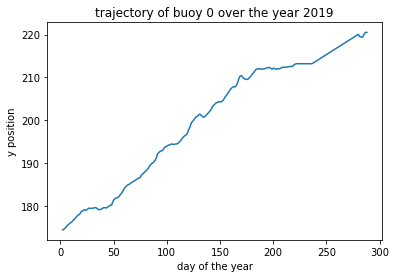

In [91]:
#Plot the y trajectory of buoy 0 over the year 2019
plt.figure()
plt.plot(df1[(df1['id_buoy'] == 0) & (df1['year'] == 2019)].loc[:, 'doy'], df1[(df1['id_buoy'] == 0) & (df1['year'] == 2019)].loc[:, 'y_EASE'])
plt.title('trajectory of buoy 0 over the year 2019')
plt.xlabel('day of the year')
plt.ylabel('y position')
plt.show()

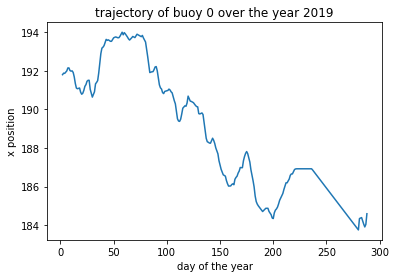

In [92]:
#Plot the x trajectory of the buoy 0 over the year 2019
plt.figure()
plt.plot(df1[(df1['id_buoy'] == 0) & (df1['year'] == 2019)].loc[:, 'doy'], df1[(df1['id_buoy'] == 0) & (df1['year'] == 2019)].loc[:, 'x_EASE'])
plt.title('trajectory of buoy 0 over the year 2019')
plt.xlabel('day of the year')
plt.ylabel('x position')
plt.show()

In order to predict the u_buoy and v_buoy we will only include relevant parameters. These include the x and y cartesian coordinates, the x and y components of the wind, sea ice concentration, sea ice thickness, and distance to coast.

In [94]:
#Split the data into independent and dependent variables
X = df1.loc[:,['x_EASE', 'y_EASE', 'u_ERA5', 'v_ERA5', 'sic_CDR','h_piomas','d2c']]
y = df1.loc[:,['u_buoy', 'v_buoy']]

In [96]:
#List of the columns for the independent variables
X.columns

Index(['x_EASE', 'y_EASE', 'u_ERA5', 'v_ERA5', 'sic_CDR', 'h_piomas', 'd2c'], dtype='object')

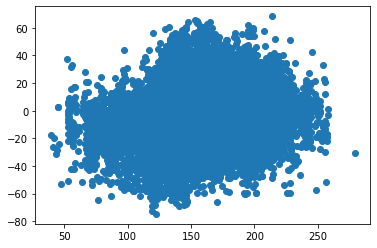

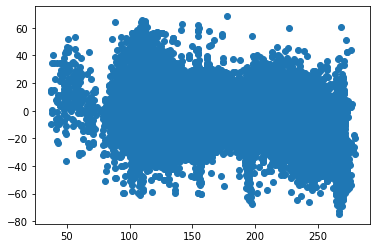

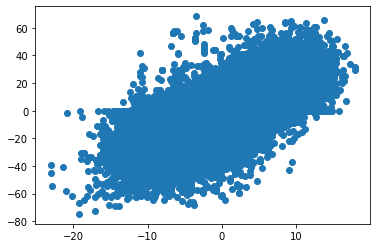

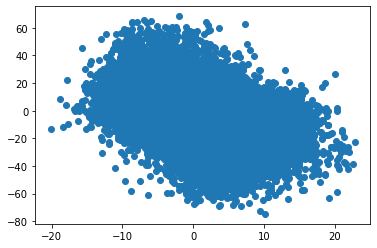

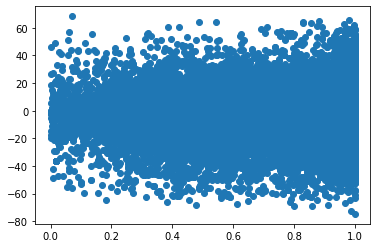

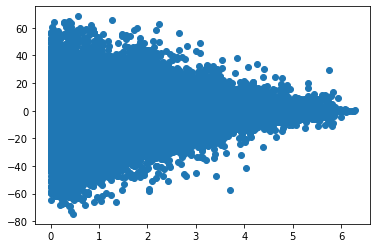

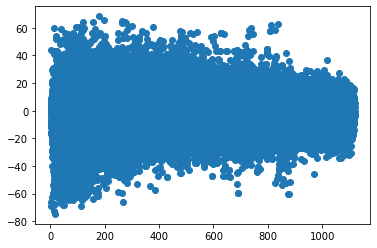

In [78]:
#Plot the independent variables vs. the velocity to see if there are linear relationships/correlations
for i in X.columns:
    plt.figure()
    plt.scatter(df1.loc[:,i], y.iloc[:,0])
    plt.show()

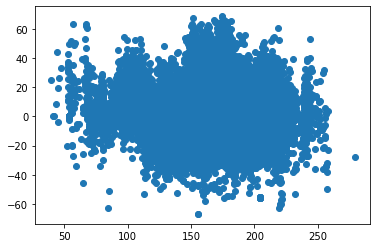

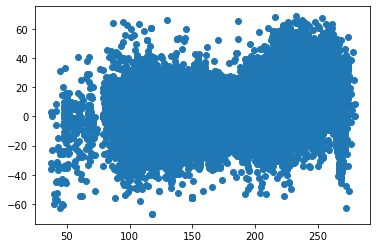

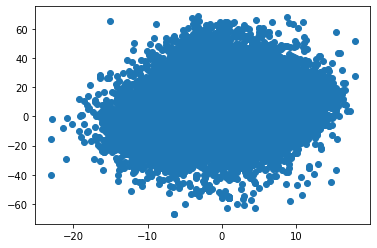

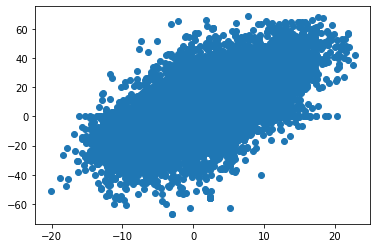

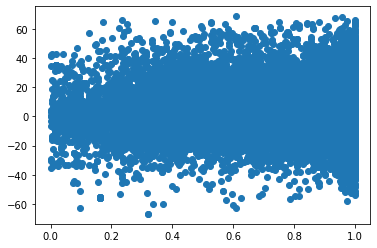

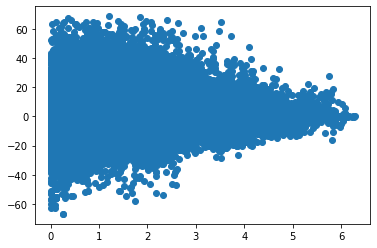

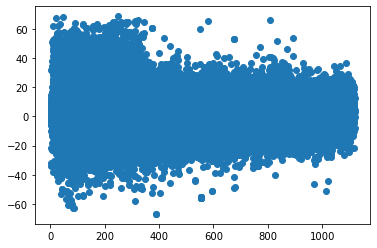

In [141]:
#Plot the independent variables vs. the velocity to see if there are linear relationships/correlations
for i in X.columns:
    plt.figure()
    plt.scatter(df1.loc[:,i], y.iloc[:,1])
    plt.show()

Therefore, based on the plots above the only variables with high correlations/linearity are between the wind components (u_ERA5, v_ERA5) and the velocity components (u_buoy, v_buoy)

## KNN

In [79]:
#Split the training data into train and test set
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

In [80]:
#Import packages
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import StandardScaler

In [81]:
#Scale the data
#Instantiate the scaler
Scaler = StandardScaler()
#Fit
Scaler.fit(X_train)
#Transform the subset of train and test data 
X_scale_train = Scaler.transform(X_train)
X_scale_test = Scaler.transform(X_test)

In [97]:
n_neighbors_range = range(1, 10)

test_scores_scaled = []
train_scores_scaled = []

test_scores = []
train_scores = []

for n in n_neighbors_range:
    
    # initialize the model
    model = KNeighborsRegressor(n_neighbors=n)

    # fit on the scaled
    model.fit(X_scale_train, y_train)

    # predict on the scaled test set and train, save results
    test_scores_scaled.append(model.score(X_scale_test, y_test))

    train_scores_scaled.append(model.score(X_scale_train, y_train))

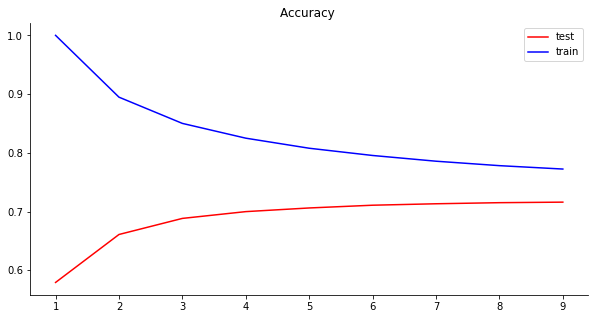

In [98]:
import seaborn as sns

# plot the scaled results
plt.figure(figsize=(10, 5))
plt.plot(n_neighbors_range, test_scores_scaled, c="red", label="test")
plt.plot(n_neighbors_range, train_scores_scaled, c="blue", label="train")
plt.title("Accuracy ")
sns.despine()
plt.legend()
plt.show()

In [105]:
KNN_model = KNeighborsRegressor(n_neighbors=8)
KNN_model.fit(X_scale_train, y_train)
print(KNN_model.score(X_scale_train, y_train))
print(KNN_model.score(X_scale_test, y_test))

0.7781482589024917
0.715111972468568


In [106]:
from sklearn.metrics import mean_squared_error 

pred_y = KNN_model.predict(X_scale_test)
mse = mean_squared_error(y_test, pred_y)
print("Mean Squared Error:",mse)

Mean Squared Error: 18.39939167400808


In [107]:
from sklearn.metrics import r2_score
r2_score(y_test,pred_y)

0.715111972468568

## Predicting Velocity For The Training Data

Use the results/model above to predict the u_buoy and v_buoy variables for the testing data

In [108]:
#Split the data into independent and dependent variables
X_df = df.loc[:,['x_EASE', 'y_EASE', 'u_ERA5', 'v_ERA5', 'sic_CDR','h_piomas','d2c']]
y_df = df.loc[:,['u_buoy', 'v_buoy']]

In [109]:
#Scale the training data
X_df_scale = Scaler.transform(X_df)

In [110]:
pred_y_df = KNN_model.predict(X_df_scale)

In [112]:
pred_y_df.shape

(84870, 2)

In [122]:
#Publish results to a csv file
y_test_results = pd.DataFrame(pred_y_df)
y_test_results.to_csv (r'C:\Users\Samantha\Documents\export_dataframe.csv', index = False, header=True)

### Neural Network

In [40]:
#Import packages
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.metrics import binary_accuracy

In [56]:
#Create model
model = keras.models.Sequential()

#Declare hidden layers
model.add(layers.Dense(X_scale_train.shape[1], activation="relu"))
model.add(layers.Dense(40, activation="relu"))
model.add(layers.Dense(40, activation="relu"))
model.add(layers.Dense(15, activation="relu"))

#Declare Output Layer
model.add(layers.Dense(2))       

#Compile the model
model.compile(
    # Optimizer
    optimizer=keras.optimizers.Adam(),  
    # Loss function to minimize
    loss=keras.losses.MeanSquaredError(),
)

In [57]:
#Train the model using 100 epochs
history = model.fit(X_scale_train, y_train, epochs= 50, verbose=1)

Epoch 1/50
8487/8487 [==============================] - 27s 3ms/step - loss: 24.1571
Epoch 2/50
8487/8487 [==============================] - 18s 2ms/step - loss: 22.1784
Epoch 3/50
8487/8487 [==============================] - 22s 3ms/step - loss: 21.7440
Epoch 4/50
8487/8487 [==============================] - 24s 3ms/step - loss: 21.4091
Epoch 5/50
8487/8487 [==============================] - 20s 2ms/step - loss: 21.1475
Epoch 6/50
8487/8487 [==============================] - 15s 2ms/step - loss: 20.8823
Epoch 7/50
8487/8487 [==============================] - 14s 2ms/step - loss: 20.6378
Epoch 8/50
8487/8487 [==============================] - 18s 2ms/step - loss: 20.4215
Epoch 9/50
8487/8487 [==============================] - 16s 2ms/step - loss: 20.2717
Epoch 10/50
8487/8487 [==============================] - 15s 2ms/step - loss: 20.1181
Epoch 11/50
8487/8487 [==============================] - 14s 2ms/step - loss: 19.9747
Epoch 12/50
8487/8487 [==============================] - 16s 2m

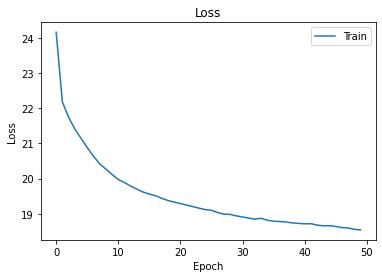

In [58]:
plt.plot(history.history['loss'])
plt.title('Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validate'])
plt.show()

In [59]:
train_loss = history.history["loss"][-1]
result = model.evaluate(X_scale_test, y_test, verbose=0)

print(f"Train Loss: {train_loss:.4f}")
print(f"Test Loss: {result:.4f}")

y_pred = model.predict(X_scale_test)

Train Loss: 18.5438
Test Loss: 19.1647


In [60]:
from sklearn.metrics import r2_score
r2_score(y_test,y_pred)

0.7033220330206693

In [61]:
from sklearn.metrics import mean_squared_error
mean_squared_error(y_test, y_pred)

19.164715768031122